Spam filter for Quora questions Download data from here : https://www.dropbox.com/sh/kpf9z73woodfssv/AAAw1_JIzpuVvwteJCma0xMla

Goal : Build a model for identifying if a question on Quora is spam

Suggested Guidelines :

To bring down dimensions of your model you can use glove embedding shared with you ( in the data )

Here is how you can use pertained embeddings : https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

You'll have to Create and maintain your own train/validation splits for the full data shared with you

Your solution needs to be uploaded to GitHub repo of your team

In [4]:
import numpy as np
import pandas as pd
from keras.layers import LSTM,GRU, Activation, Dense, Dropout,Flatten, Input, Embedding
from keras.models import Model

from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers import MaxPooling1D , GlobalMaxPooling1D

Using TensorFlow backend.


In [5]:
!wget https://www.dropbox.com/sh/kpf9z73woodfssv/AAAwZ5DDt-aHwqZFHYrZ-ZBHa/train.csv

--2020-01-28 17:59:45--  https://www.dropbox.com/sh/kpf9z73woodfssv/AAAwZ5DDt-aHwqZFHYrZ-ZBHa/train.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/kpf9z73woodfssv/AAAwZ5DDt-aHwqZFHYrZ-ZBHa/train.csv [following]
--2020-01-28 17:59:45--  https://www.dropbox.com/sh/raw/kpf9z73woodfssv/AAAwZ5DDt-aHwqZFHYrZ-ZBHa/train.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbae2021e2ae6292312caea75d1.dl.dropboxusercontent.com/cd/0/inline/AxCcv2_PxGFWf6RGkb_naZDAhfu6Axpr9L2D_TTz7exF2mOjtLdDY2TATO5FWLu5R0zamv3JD1BkET86LJ8pHVRRzPgK--HRfAk992YCuJTQyg/file# [following]
--2020-01-28 17:59:46--  https://ucbae2021e2ae6292312caea75d1.dl.dropboxusercontent.com/cd/0/inline/AxCcv2_PxGFWf6RGkb_naZDAhfu6Axpr9L2D_TTz7exF2mOjtLdDY2TATO5FWLu

In [6]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-01-28 17:59:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-28 17:59:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-28 17:59:54--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [7]:
#unzip the file 
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
#store 300 size vector representation different words from the file to a disctionary
embedding_index = {}
f = open('glove.6B.300d.txt',encoding='utf-8')
for line in f:
  value = line.split()
  word = value[0]
  coeffs = np.asarray(value[1:],dtype = 'float32')
  embedding_index[word] = coeffs
f.close()

In [9]:
len(embedding_index)

400000

In [0]:
quora_d = pd.read_csv ("/content/train.csv")# reading csv

In [11]:
quora_d.shape

(1306122, 3)

In [12]:
quora_d.tail()

,qid,question_text,target
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


In [24]:
quora_d['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

Class 0: 1225312
Class 1: 80810
Proportion: 15.16 : 1


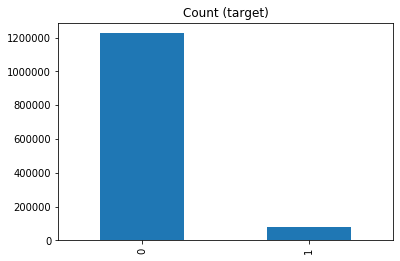

In [25]:
#to check the proportion of the ones to zeros
target_count = quora_d['target'].value_counts()

print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

the above graph shows we have inbalence classes 

In [0]:
from sklearn.model_selection import train_test_split
q_train , q_test = train_test_split(quora_d, test_size=0.2)

In [28]:
q_train.shape , q_test.shape

((1044897, 3), (261225, 3))

In [0]:
x_train = q_train['question_text']
y_train = q_train['target']
x_test  = q_test['question_text']
y_test  = q_test['target']

In [30]:
x_train.shape , y_train.shape , x_test.shape , y_test.shape

((1044897,), (1044897,), (261225,), (261225,))

In [31]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([0.53294757, 8.08781368])

In [32]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import LSTM,Activation,Dense,Input,Embedding,Dropout
from keras.models import Model
from nltk import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
sent_lens=[len(word_tokenize(x)) for x in x_train]

In [34]:
print(word_tokenize(x) for x in x_train)

<generator object <genexpr> at 0x7f3ae4097468>


In [35]:
min(sent_lens)

1

In [36]:
max(sent_lens)

412

In [37]:
np.percentile(sent_lens,95)

30.0

In [0]:
max_len=31 #taking the 95% quantile value of the sentence length

tk=Tokenizer(char_level=False,split=' ') # tokenizing the sentence 

tk.fit_on_texts(x_train)

seq_train=tk.texts_to_sequences(x_train) # create tokens on train
seq_test=tk.texts_to_sequences(x_test) # create tokens on test

vocab_size=len(tk.word_index)

seq_train_matrix=sequence.pad_sequences(seq_train,maxlen=max_len) #padding the sentence with 0 for matching length
seq_test_matrix=sequence.pad_sequences(seq_test,maxlen=max_len)

In [39]:
seq_train_matrix.shape , seq_test_matrix.shape , vocab_size

((1044897, 31), (261225, 31), 195905)

In [40]:
seq_train_matrix[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,   11,    1,  853,   37,   83,   36,  940,
         36,   47,   12,   67, 2249,   83,  565,    3,  282], dtype=int32)

In [0]:
# creating our own embedding matrix to bring down the size to 300
# we'll use 300 D vector representation of the words from pretrained embedding index 
# that we downloaded 

embedding_matrix=np.zeros((vocab_size+1,300))

for word,i in tk.word_index.items():
    embed_vector=embedding_index.get(word)
    if embed_vector is not None:
        embedding_matrix[i]=embed_vector
# if there are specific words which are not present in pretrained embedding 
# their weights will remain 0. if there are too many such words 
# then you should probably not use pretrained embeddings

now we can try to make model with GRU

In [42]:
inputs=Input(name='text_input',shape=[max_len])
embed=Embedding(vocab_size+1,300,input_length=max_len,mask_zero=True,
                weights=[embedding_matrix],trainable=False)(inputs)

GRU_layer=GRU(50)(embed)

dense1=Dense(10,activation='relu')(GRU_layer)
drop=Dropout(0.2)(dense1)

final_layer=Dense(1,activation='sigmoid')(drop)

model_GRU=Model(inputs=inputs,outputs=final_layer)










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [43]:
inputs=Input(name='text_input',shape=[max_len])
embed=Embedding(vocab_size+1,300,input_length=max_len,mask_zero=True,
                weights=[embedding_matrix],trainable=False)(inputs)

GRU_layer=GRU(50)(embed)

dense1=Dense(10,activation='relu')(GRU_layer)
drop=Dropout(0.2)(dense1)

final_layer=Dense(1,activation='sigmoid')(drop)

model_GRU=Model(inputs=inputs,outputs=final_layer)
model_GRU.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      (None, 31)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 31, 300)           58771800  
_________________________________________________________________
gru_2 (GRU)                  (None, 50)                52650     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 58,824,971
Trainable params: 53,171
Non-trainable params: 58,771,800
__________________________________________

In [0]:
from keras.callbacks import ModelCheckpoint
import os
outputFolder = './content/Model_output/'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath = outputFolder+"/weights-{epoch:02d}-{val_acc:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=False, save_weights_only=True, 
                             mode='auto', period=1)
# this will save the weights every 10 epoch

from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3,
                          verbose=1, mode='auto')

In [45]:
model_GRU.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
from keras.callbacks import ModelCheckpoint
import os
outputFolder = './content/Model_output/'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath = outputFolder+"/weights-{epoch:02d}-{val_acc:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=False, save_weights_only=True, 
                             mode='auto', period=1)
# this will save the weights every 10 epoch

from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3,
                          verbose=1, mode='auto')

In [48]:
model_GRU.fit(seq_train_matrix,y_train,validation_data=[seq_test_matrix,y_test],epochs=10,class_weight={0:0.53,1:8},
          batch_size=10000,callbacks=[earlystop,checkpoint])



Train on 1044897 samples, validate on 261225 samples
Epoch 1/10
1044897/1044897 [==============================] - 395s 378us/step - loss: 0.4271 - acc: 0.7948 - val_loss: 0.3443 - val_acc: 0.8500

Epoch 00001: saving model to ./content/Model_output//weights-01-0.8500.h5
Epoch 2/10
1044897/1044897 [==============================] - 390s 373us/step - loss: 0.3169 - acc: 0.8646 - val_loss: 0.3666 - val_acc: 0.8345

Epoch 00002: saving model to ./content/Model_output//weights-02-0.8345.h5
Epoch 3/10
1044897/1044897 [==============================] - 393s 376us/step - loss: 0.2970 - acc: 0.8718 - val_loss: 0.3155 - val_acc: 0.8650

Epoch 00003: saving model to ./content/Model_output//weights-03-0.8650.h5
Epoch 4/10
1044897/1044897 [==============================] - 400s 383us/step - loss: 0.2844 - acc: 0.8783 - val_loss: 0.2672 - val_acc: 0.8870

Epoch 00004: saving model to ./content/Model_output//weights-04-0.8870.h5
Epoch 5/10
1044897/1044897 [==============================] - 395s 37

In [49]:
p=model_GRU.predict(seq_test_matrix)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,p)

0.9579191791359627

In [50]:
from sklearn.metrics import classification_report,f1_score
print(f1_score(y_test,p >.50))

0.49377586464790835


In [51]:
print(classification_report(y_test,p>.50))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93    245012
           1       0.34      0.92      0.49     16213

    accuracy                           0.88    261225
   macro avg       0.67      0.90      0.71    261225
weighted avg       0.95      0.88      0.91    261225



In [0]:
from keras.models import load_model

model_GRU.save('Project3_Model.h5')  # creates a HDF5 file 'my_model.h5'

In [53]:
# serialize model to JSON
model_json = model_GRU.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_GRU.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [56]:
p

array([[0.50884783],
       [0.06489378],
       [0.59140193],
       ...,
       [0.15317315],
       [0.44833362],
       [0.6457561 ]], dtype=float32)

In [0]:
#submitted by mukesh b